# <font color=blus>Table of contents</font>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, last_level=4, header="Result issued from biais metrics")

# <font color=blus> Abstract</font>

    This notebook aims to expose bias preformances over CNN model built from notebook CNN_BinaryClassifier.
    
    1) Input data for validation is loaded. This data is issued from DataPreparator notebook.
    
    2) Model issued from CNN_binaryClassifier notebook is loaded and predictions are computed over validation dataset.
    
    3) Bias performance is computed using formula provided into kaggle Jigsaw https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation
    

# <font color=blus> Software engineering</font>
<img src="./img/SoftwareEngineeringBiasMetrics.png">

In [30]:
from sklearn import metrics
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [7]:
import p9_util

TOXICITY_COLUMN = p9_util.COLUMN_NAME_TARGET
TEXT_COLUMN = p9_util.COLUMN_NAME_DOC

# Create a text tokenizer.
#tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
#tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
MODEL_NAME='predict'

# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']


# <font color=blus> 1. Loading dataset</font>

Dataset is extracted from ̀`DataPreparator` object configured for validation.

Such object contains 
* parameters used for processing data digitalization that leads to build `DataPreparator` object
* list of files saved on hard-disk for data validation.

See `DataPreparator.ipynb` notebook, for more details.

## <font color='blus'> 1.1 Load `DataPreparator` for validation</font>

In [4]:
import p5_util
filename = "./data/dataPreparator_valid_12000.dill"
if True:
    dataprep = p5_util.object_load(filename)
else :
    p5_util.object_dump(dataprep,filename)
self = dataprep


p5_util.object_load : fileName= ./data/dataPreparator_valid_12000.dill


In [5]:
self.list_df_data_file

['./data/df_dataprep_matrix_32.dill',
 './data/df_dataprep_matrix_82.dill',
 './data/df_dataprep_matrix_57.dill',
 './data/df_dataprep_matrix_122.dill',
 './data/df_dataprep_matrix_118.dill',
 './data/df_dataprep_matrix_86.dill',
 './data/df_dataprep_matrix_66.dill',
 './data/df_dataprep_matrix_52.dill',
 './data/df_dataprep_matrix_30.dill',
 './data/df_dataprep_matrix_79.dill',
 './data/df_dataprep_matrix_36.dill',
 './data/df_dataprep_matrix_109.dill']

    Once a file is loaded as a dataframe then original index column is added.
    
    This operation allows to join columns from original dataframe with 
    the dataframe columns issued from CNN model computation.
    

In [6]:
import pandas as pd
import p5_util

filename = self.list_df_data_file[0]
max_row = 20000
start_row = 0
self.df_data = pd.DataFrame()
for filename in self.list_df_data_file :
    
    df_data = p5_util.object_load(filename)
    end_row = start_row +len(df_data)
    
    if end_row > max_row :
        break
    else :
        self.df_data = pd.concat([self.df_data,df_data])
        start_row = end_row
    
self.df_data.reset_index(inplace=True)
self.df_data.rename(columns={'index':'original_index'}, inplace=True)
self.df_data.sample(3)

p5_util.object_load : fileName= ./data/df_dataprep_matrix_32.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_82.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_57.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_122.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_118.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_86.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_66.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_52.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_30.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_79.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_36.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_109.dill


,original_index,docs,counting,tokens,matrix_padded,target
1018,960507,if you spend $100 on something this year and s...,15,"[spend, year, spend, year, increase, spending,...","[[0.00894519966095686, -0.05881800130009651, 0...",0
6035,226247,"you wont do anything about your stupidity! , s...",12,"[will, not, stupidity, loser, wall, know, carb...","[[0.027164999395608902, 0.29879000782966614, -...",1
8261,106454,nasty little piece by a person who represents ...,64,"[nasty, little, piece, person, represent, poli...","[[-0.8571299910545349, -0.3146800100803375, -0...",1


    Make data to be compliant for CNN model input layer.

In [7]:
import numpy as np

X = self.df_data.matrix_padded
print(X.shape)
#-----------------------------------------------------------------------
# Prepare input data in order to feed model prediction function : 
#    * Complete tuple of dimensions, out of 1st dimension.
#    * Compute shape for data feeding predictor.
#    * Initialize array with shape previously computed
#    * Transfer data into input
#-----------------------------------------------------------------------
list_tuple = list()
list_tuple.append(len(X))
for shape in X.iloc[0].shape:
    list_tuple.append(shape)

input_shape = tuple(i for i in list_tuple)
x_input = np.zeros(input_shape)

for item in range(len(X)):
    x_input[item]= X.values[item].copy()
input_model = x_input.copy()

(12000,)


    Save memory

In [12]:
del(x_input)

In [13]:
input_model.shape

(12000, 100, 300)

# <font color='blus'>2. Process to predictions</font>

## <font color='blus'> 2.1. Loading CNN model</font>

In [8]:
import keras

filename_model = './data/benchmark/model_jigsaw_submission_sample129651_threshold0.5_best_save.h5'
model = keras.models.load_model(filename_model)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 300)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 300)          1200      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 256)          153856    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 256)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 256)           1024      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 256)           196864    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 256)            0         
__________

    Make predictions and convert them into binary values.

In [15]:
self.df_data['predict'] = model.predict(input_model)[:,1]

In [20]:
arr_index = self.df_data['predict'].sample(5).index
self.df_data['predict'].loc[arr_index]

11681    0.848653
9189     0.514631
7251     0.013169
5568     0.003650
8648     0.958515
Name: predict, dtype: float32

In [21]:
import numpy as np
self.df_data['predict'] = np.where(self.df_data['predict'] >= 0.5, 1, 0)

In [26]:
self.df_data['predict'].loc[arr_index]

11681    1
9189     1
7251     0
5568     0
8648     1
Name: predict, dtype: int64

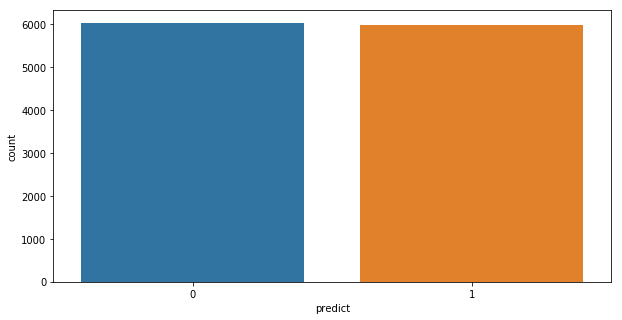

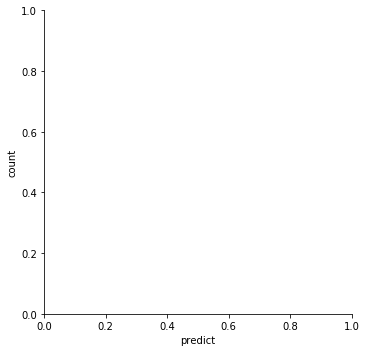

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
_ = sns.catplot(ax=ax, x='predict', data=self.df_data, kind='count')

## <font color='blus'> 2.2 Load original dataset into df_train dataframe.</font>

For bias computation, informations from original dataset has to be linked with those issued from predicions.

In [31]:
import pandas as pd
import p5_util
df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

### <font color='blus'>2.2.1. Build of df_identity dataframe.</font>

    For bias evaluation, df_identity dataframe is built from original dataframe.
    
    Columns from df_identity dataframe are required.
    
    Due to this, a join process between dataframe issued from CNN computation and df_identity 
    dataframe takes place.

In [32]:
identity_columns+['target','id']

['male',
 'female',
 'homosexual_gay_or_lesbian',
 'christian',
 'jewish',
 'muslim',
 'black',
 'white',
 'psychiatric_or_mental_illness',
 'target',
 'id']

In [33]:
#----------------------------------------------------------------------------
# Filter rows from original dataset with original indexes stored into 
# self.df_data
#----------------------------------------------------------------------------
filtered_index = self.df_data[p9_util.COLUMN_NAME_INDEX]

#----------------------------------------------------------------------------
# Apply filtered_index indexes over columns of df_indetity dataframe.
#----------------------------------------------------------------------------
df_identity = df_train.loc[filtered_index.values][identity_columns+['target','id']]

#----------------------------------------------------------------------------
# Reset indexes of df_identity dataframe;  new index column is renamed 
# original_index.
#----------------------------------------------------------------------------
df_identity.reset_index(inplace=True)


df_identity.rename(columns={'index':'original_index'}, inplace=True)
print(df_identity.columns)

Index(['original_index', 'male', 'female', 'homosexual_gay_or_lesbian',
       'christian', 'jewish', 'muslim', 'black', 'white',
       'psychiatric_or_mental_illness', 'target', 'id'],
      dtype='object')


    Save memory

In [34]:
del(df_train)

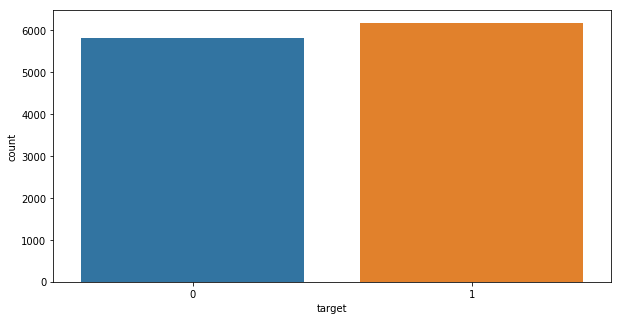

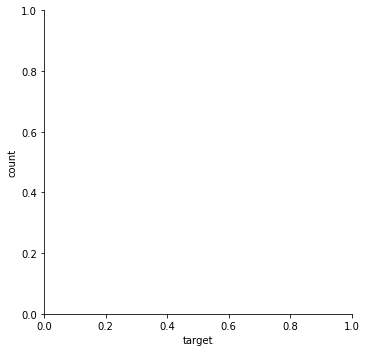

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
_ = sns.catplot(ax=ax, x='target', data=df_identity, kind='count')

    Get 3 randoms rows from df_identity dataframe and let's check corresponding columns values
    do match with original dataset (df_train is the original dataset).
    
    Visual check is applied on columns id values for each dataframe.

In [39]:
arr_index = df_identity.original_index.sample(3).values
df_identity[df_identity['original_index'].isin(arr_index)]

,original_index,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target,id
7160,273735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,577593
8428,717869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5000681
10827,1728118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6241141


    target column from df_identity dataframe is converted as a binary vector with same threshold 
    fixed for CNN model.  
    
    This way, model performance will be measure aagiant df_identity true values.

In [37]:
import numpy as np
df_identity['target'] = np.where(df_identity['target'] >= 0.5, 1, 0)

    Visual check over target column name.

In [40]:
df_identity[df_identity['original_index'].isin(arr_index)]

,original_index,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target,id
7160,273735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,577593
8428,717869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5000681
10827,1728118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6241141


    Note below that true label values in target column are compared with predicted values in predict column.

In [41]:
self.df_data[self.df_data['original_index'].isin(arr_index)]

,original_index,docs,counting,tokens,matrix_padded,target,predict
7160,273735,wrong article dude.,3,"[wrong, article, dude]","[[-0.20095999538898468, 0.37617000937461853, -...",0,1
8428,717869,i guess it is time to visit saudi arabia.,5,"[guess, time, visit, saudi, arabia]","[[-0.22257000207901, 0.35071998834609985, -0.4...",0,0
10827,1728118,if this is 'front page' news in canada's natio...,59,"[page, news, national, paper, state, sanction,...","[[-0.1781499981880188, 0.2525700032711029, 0.1...",0,0


    Join dataframe issued from data processing with identities dataframe.
    This join operation is based on original_index

In [42]:
df_identity = df_identity.join(self.df_data.set_index('original_index'), on='original_index', lsuffix='true_')

df_identity.columns

Index(['original_index', 'male', 'female', 'homosexual_gay_or_lesbian',
       'christian', 'jewish', 'muslim', 'black', 'white',
       'psychiatric_or_mental_illness', 'targettrue_', 'id', 'docs',
       'counting', 'tokens', 'matrix_padded', 'target', 'predict'],
      dtype='object')

    df_identity dataframe is now assigned with predict column, as shown on display below.

In [43]:
df_identity[df_identity['original_index'].isin(arr_index)]

,original_index,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,targettrue_,id,docs,counting,tokens,matrix_padded,target,predict
7160,273735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,577593,wrong article dude.,3,"[wrong, article, dude]","[[-0.20095999538898468, 0.37617000937461853, -...",0,1
8428,717869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5000681,i guess it is time to visit saudi arabia.,5,"[guess, time, visit, saudi, arabia]","[[-0.22257000207901, 0.35071998834609985, -0.4...",0,0
10827,1728118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6241141,if this is 'front page' news in canada's natio...,59,"[page, news, national, paper, state, sanction,...","[[-0.1781499981880188, 0.2525700032711029, 0.1...",0,0


# <font color='blus'> 3.0 Bias metrics computation</font>

In [45]:
identity = 'male'
df_identity[identity].dropna().sample(3)

5407     0.0
7187     0.0
10802    0.9
Name: male, dtype: float64

In [47]:
import numpy as np
import p9_util_benchmark
threshold = p9_util_benchmark.dict_param_benchmark['threshold']
print(threshold)

0.5


In [50]:
for identity in identity_columns :
    df_identity[identity] = np.where(df_identity[identity] >= threshold, True, False)

In [51]:
import p9_util_metrics

bias_metrics_df = p9_util_metrics.compute_bias_metrics_for_model(df_identity, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.838230,0.677445,homosexual_gay_or_lesbian,0.653935,156
6,0.881206,0.634381,black,0.654802,207
7,0.890476,0.644137,white,0.673026,356
5,0.874815,0.703863,muslim,0.717084,228
0,0.860847,0.798105,male,0.796978,384
3,0.826641,0.837131,christian,0.801983,298
8,0.912722,0.756079,psychiatric_or_mental_illness,0.808608,53
1,0.850252,0.821484,female,0.809793,427
4,0.846957,0.835122,jewish,0.821569,71


In [52]:
overall_auc = p9_util_metrics.calculate_overall_auc(df_identity, MODEL_NAME, p9_util_metrics.TOXICITY_COLUMN)
print("Global AUC = {}".format(overall_auc))

Global AUC = 0.8603102910713905


In [53]:
p9_util_metrics.get_final_metric(bias_metrics_df, overall_auc)

Bias score contribution : 0.5780288471789291


0.7931064199467768

# <font color='blus'> 4.0 Binary classification performances</font>

**If memory resources are too weak due to previous steps, the restart kernel and execute cell below.**

    Load data generator objects for train and validation.

In [2]:
import p5_util

filename_train = './data/train_generator.dill'
filename_valid = './data/valid_generator.dill'

train_generator = p5_util.object_load(filename_train)
valid_generator = p5_util.object_load(filename_valid)


p5_util.object_load : fileName= ./data/train_generator.dill


Using TensorFlow backend.
/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
W1104 18:21:11.466108 139675099850560 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1104 18:21:11.466760 139675099850560 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W1104 18:2

p5_util.object_load : fileName= ./data/valid_generator.dill


    Extract digitalized data from datagenerator sources to feed model as input.
    
    This step may take few minutes...

In [3]:
import numpy as np

X_valid = valid_generator.X
y_valid = valid_generator.y

Load trained CNN model issued from `CNN_BinaryClassifier` notebook.

In [4]:
import keras

filename_model = './data/benchmark/model_jigsaw_submission_sample129651_threshold0.5_best_save.h5'
model = keras.models.load_model(filename_model)

model.summary()

W1104 18:22:17.019239 139675099850560 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1104 18:22:17.148776 139675099850560 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1104 18:22:17.149234 139675099850560 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1104 18:22:17.163434 139675099850560 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 300)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 300)          1200      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 256)          153856    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 256)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 256)           1024      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 256)           196864    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 256)            0         
__________

    Apply predictions over validation dataset.

In [5]:
import numpy as np

y_predict = model.predict(X_valid, verbose=1)

y_predict_round = np.round(y_predict).astype(int)

12000/12000 [==============================] - 11s 955us/step


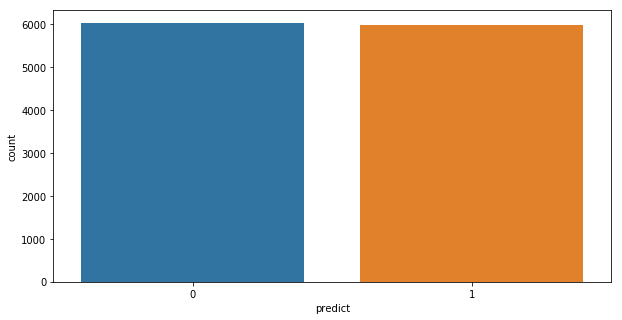

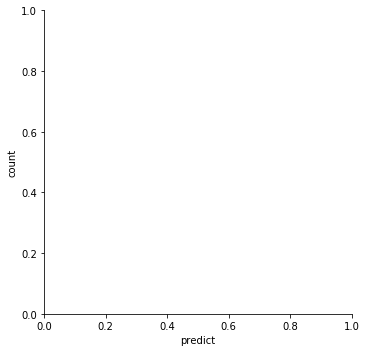

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
_ = sns.catplot(ax=ax, x='predict', data=pd.DataFrame(y_predict_round[:,1], columns=['predict']), kind='count')

    Display CNN model performances 

/home/bangui/.local/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/bangui/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[0, 1]

Confusion matrix for all classes : 

[[5267  925]
 [ 755 5053]]

Normalized confusion matrix
[[0.8506137  0.1493863 ]
 [0.12999311 0.87000689]]
Confusion matrix, without normalization
[[5267  925]
 [ 755 5053]]

TP rate = [0.         0.87000689 1.        ]
FP rate = [0.        0.1493863 1.       ]
AUC = 0.8603102910713905


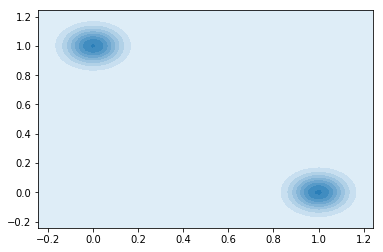

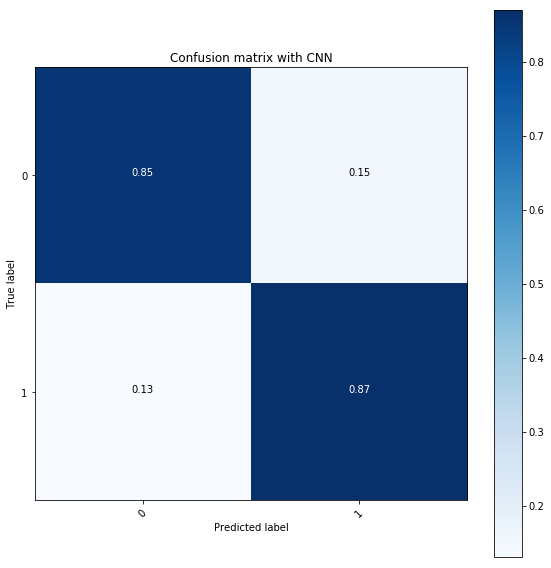

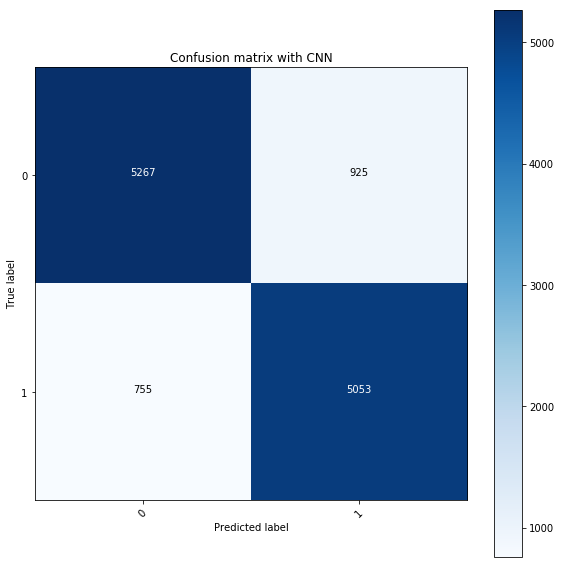

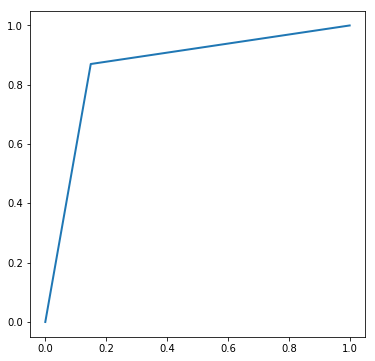

In [6]:
import p9_util

y_= p9_util.display_class_performance(model, None, y_valid, is_binary=True, \
                                      y_pred=y_predict_round, nb_classes=2,\
                                      title="Confusion matrix with CNN")